In [1]:
#! pip install xgboost==0.90

In [2]:
#! pip install --upgrade scikit-learn

In [3]:
#! pip install --upgrade pandas

In [4]:
import xgboost

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# algorithms
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# ensemble learning
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier

# metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as ss

# suppress anoying warnings
import warnings
warnings.filterwarnings("ignore")

## Raw data

In [6]:
df = pd.read_csv('Dane/pima-indians-diabetes.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
X = df.iloc[:, :8]
y = df.iloc[:,8]

In [8]:
print(X.shape)
print(np.mean(y))

(768, 8)
0.3489583333333333


In [9]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

## Trying different models

In [10]:
def get_roc_auc(model, X, y):
    y_score = model.predict_proba(X)[:, 1] # take the probability of the label 1
    return roc_auc_score(y_true=y.values, y_score=y_score)  

def get_accuracy(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y_true=y, y_pred=y_pred)

def get_performance(model, X, y):
    return f"Accuracy: {get_accuracy(model, X, y): .2f}, AUC: {get_roc_auc(model, X, y): .3f} "

In [11]:
models = [LogisticRegression(),
          DecisionTreeClassifier(),
          SVC(probability=True), 
          LinearDiscriminantAnalysis(), 
          RandomForestClassifier(),
          KNeighborsClassifier()]

names = ['LR', 'DT', 'SVC', 'LDA', 'RF', 'KNN']

basic_acc = {}

for model, name in zip(models, names):
    model.fit(X_train, y_train)
    
    performance = get_performance(model, X_test, y_test)
    basic_acc[name] = performance
    

In [12]:
basic_acc

{'LR': 'Accuracy:  0.79, AUC:  0.831 ',
 'DT': 'Accuracy:  0.70, AUC:  0.677 ',
 'SVC': 'Accuracy:  0.75, AUC:  0.812 ',
 'LDA': 'Accuracy:  0.77, AUC:  0.831 ',
 'RF': 'Accuracy:  0.76, AUC:  0.815 ',
 'KNN': 'Accuracy:  0.69, AUC:  0.738 '}

## Combinig Classifiers

In [13]:
VotingClassifier?

In [14]:
models = [LogisticRegression(),
          DecisionTreeClassifier(),
          SVC(probability=True), 
          LinearDiscriminantAnalysis(), 
          RandomForestClassifier(),
          KNeighborsClassifier()]

names = ['LR', 
         'DT', 
         'SVC', 
         'LDA', 
         'RF', 
         'KNN']

### Voting hard

In [15]:
model_hard = VotingClassifier(estimators=list(zip(names, models)), voting="hard")
model_hard.fit(X_train, y_train)

# no probability here so no ROC AUC
model_hard.score(X_test, y_test)

0.7677165354330708

### Voting soft 

In [16]:
model_soft = VotingClassifier(estimators=list(zip(names, models)), voting="soft")
model_soft.fit(X_train, y_train)

get_performance(model_soft, X_test, y_test)

'Accuracy:  0.76, AUC:  0.825 '

## Bagging
* Random Forest

In [17]:
RandomForestClassifier?

In [18]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)

get_performance(rf, X_test, y_test)

'Accuracy:  0.78, AUC:  0.831 '

## Stacking

In [19]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          SVC(random_state=42)))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)


clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(random_state=42))]))],
                   final_estimator=LogisticRegression())

In [20]:
get_performance(clf, X_test, y_test)

'Accuracy:  0.75, AUC:  0.837 '

## Zadanie 
1. zbudować model RF, zmieniając głębokość drzew - 3 opcje. Czy to wpływa na dokładnośc modelu?
2. zbudować model metodą Stacking
    * estimators - DT, RF, LR
    * final_estimator => SVC

## Boosting


In [21]:
?XGBClassifier

In [22]:
model = XGBClassifier()
model.fit(X_train, y_train)

get_performance(model, X_test, y_test)

'Accuracy:  0.78, AUC:  0.821 '

## XGBoost Hyper-parameters tuning
* many parameters and hard to tune;
* there are best practices - look how others do that :-)
* grid search is not an optimal solution because it will take a very long time (there are a lot of parameters to tune)

In [23]:
xgb = XGBClassifier(random_state=100)
params = {
    "n_estimators": [5,10,20],
    "learning_rate": [0.1, 0.2, 0.3]
}

gscv1 = GridSearchCV(param_grid=params, estimator=xgb,cv=20)
gscv1.fit(X_train,y_train)

GridSearchCV(cv=20, estimator=XGBClassifier(random_state=100),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'n_estimators': [5, 10, 20]})

In [24]:
gscv1.best_score_, gscv1.best_params_

(0.7605384615384616, {'learning_rate': 0.1, 'n_estimators': 5})

In [25]:
gscv1.best_params_
gscv1.best_estimator_.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 5,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 100,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [26]:
# initialize using previous best params and add a new grid search
xgb = XGBClassifier(**gscv1.best_params_)

params = {"max_depth": [3,4,5],
         "min_child_weight": [3, 5, 7, 10 ,15, 20]}
gscv2 = GridSearchCV(param_grid=params, estimator=xgb,cv=20)
gscv2.fit(X_train,y_train)

GridSearchCV(cv=20, estimator=XGBClassifier(n_estimators=5),
             param_grid={'max_depth': [3, 4, 5],
                         'min_child_weight': [3, 5, 7, 10, 15, 20]})

In [27]:
gscv2.best_score_, gscv2.best_params_

(0.77, {'max_depth': 3, 'min_child_weight': 10})

* We can go at once but it will take much time 
* We can iteratively
* it is not optimal solution

## Randomized Search

In [28]:
xgb = XGBClassifier()
params = {"n_estimators":[10,100,200],
         "learning_rate":ss.uniform(0.01,0.3),
          "max_depth": ss.randint(5,30),
         "min_child_weight":ss.randint(5,50),
         "reg_lambda":ss.uniform(0.1,3)}

cv = RandomizedSearchCV(cv=5, 
                        estimator=xgb,
                        param_distributions=params,
                        n_iter=30,
                        verbose=100)
cv.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START learning_rate=0.1762192636949702, max_depth=10, min_child_weight=30, n_estimators=200, reg_lambda=1.9019168836105433
[CV 1/5; 1/30] END learning_rate=0.1762192636949702, max_depth=10, min_child_weight=30, n_estimators=200, reg_lambda=1.9019168836105433;, score=0.796 total time=   0.0s
[CV 2/5; 1/30] START learning_rate=0.1762192636949702, max_depth=10, min_child_weight=30, n_estimators=200, reg_lambda=1.9019168836105433
[CV 2/5; 1/30] END learning_rate=0.1762192636949702, max_depth=10, min_child_weight=30, n_estimators=200, reg_lambda=1.9019168836105433;, score=0.786 total time=   0.0s
[CV 3/5; 1/30] START learning_rate=0.1762192636949702, max_depth=10, min_child_weight=30, n_estimators=200, reg_lambda=1.9019168836105433
[CV 3/5; 1/30] END learning_rate=0.1762192636949702, max_depth=10, min_child_weight=30, n_estimators=200, reg_lambda=1.9019168836105433;, score=0.699 total time=   0.0s
[CV 4/5; 1/30] ST

[CV 1/5; 9/30] END learning_rate=0.21686659515172405, max_depth=7, min_child_weight=39, n_estimators=200, reg_lambda=1.8542591130054102;, score=0.748 total time=   0.0s
[CV 2/5; 9/30] START learning_rate=0.21686659515172405, max_depth=7, min_child_weight=39, n_estimators=200, reg_lambda=1.8542591130054102
[CV 2/5; 9/30] END learning_rate=0.21686659515172405, max_depth=7, min_child_weight=39, n_estimators=200, reg_lambda=1.8542591130054102;, score=0.748 total time=   0.0s
[CV 3/5; 9/30] START learning_rate=0.21686659515172405, max_depth=7, min_child_weight=39, n_estimators=200, reg_lambda=1.8542591130054102
[CV 3/5; 9/30] END learning_rate=0.21686659515172405, max_depth=7, min_child_weight=39, n_estimators=200, reg_lambda=1.8542591130054102;, score=0.670 total time=   0.0s
[CV 4/5; 9/30] START learning_rate=0.21686659515172405, max_depth=7, min_child_weight=39, n_estimators=200, reg_lambda=1.8542591130054102
[CV 4/5; 9/30] END learning_rate=0.21686659515172405, max_depth=7, min_child_we

[CV 3/5; 15/30] END learning_rate=0.07984009898313492, max_depth=22, min_child_weight=6, n_estimators=100, reg_lambda=0.762321024868358;, score=0.680 total time=   0.0s
[CV 4/5; 15/30] START learning_rate=0.07984009898313492, max_depth=22, min_child_weight=6, n_estimators=100, reg_lambda=0.762321024868358
[CV 4/5; 15/30] END learning_rate=0.07984009898313492, max_depth=22, min_child_weight=6, n_estimators=100, reg_lambda=0.762321024868358;, score=0.796 total time=   0.0s
[CV 5/5; 15/30] START learning_rate=0.07984009898313492, max_depth=22, min_child_weight=6, n_estimators=100, reg_lambda=0.762321024868358
[CV 5/5; 15/30] END learning_rate=0.07984009898313492, max_depth=22, min_child_weight=6, n_estimators=100, reg_lambda=0.762321024868358;, score=0.706 total time=   0.0s
[CV 1/5; 16/30] START learning_rate=0.19980832721096986, max_depth=19, min_child_weight=36, n_estimators=200, reg_lambda=0.723485776173083
[CV 1/5; 16/30] END learning_rate=0.19980832721096986, max_depth=19, min_child

[CV 4/5; 21/30] END learning_rate=0.1094288885274105, max_depth=25, min_child_weight=14, n_estimators=100, reg_lambda=2.751597122388221;, score=0.757 total time=   0.0s
[CV 5/5; 21/30] START learning_rate=0.1094288885274105, max_depth=25, min_child_weight=14, n_estimators=100, reg_lambda=2.751597122388221
[CV 5/5; 21/30] END learning_rate=0.1094288885274105, max_depth=25, min_child_weight=14, n_estimators=100, reg_lambda=2.751597122388221;, score=0.725 total time=   0.0s
[CV 1/5; 22/30] START learning_rate=0.278867075404991, max_depth=7, min_child_weight=46, n_estimators=10, reg_lambda=2.5591042147621814
[CV 1/5; 22/30] END learning_rate=0.278867075404991, max_depth=7, min_child_weight=46, n_estimators=10, reg_lambda=2.5591042147621814;, score=0.660 total time=   0.0s
[CV 2/5; 22/30] START learning_rate=0.278867075404991, max_depth=7, min_child_weight=46, n_estimators=10, reg_lambda=2.5591042147621814
[CV 2/5; 22/30] END learning_rate=0.278867075404991, max_depth=7, min_child_weight=46

[CV 4/5; 28/30] END learning_rate=0.18025667653764996, max_depth=9, min_child_weight=44, n_estimators=100, reg_lambda=2.3992941782338235;, score=0.767 total time=   0.0s
[CV 5/5; 28/30] START learning_rate=0.18025667653764996, max_depth=9, min_child_weight=44, n_estimators=100, reg_lambda=2.3992941782338235
[CV 5/5; 28/30] END learning_rate=0.18025667653764996, max_depth=9, min_child_weight=44, n_estimators=100, reg_lambda=2.3992941782338235;, score=0.686 total time=   0.0s
[CV 1/5; 29/30] START learning_rate=0.30141279700912893, max_depth=7, min_child_weight=32, n_estimators=200, reg_lambda=1.9109259225749111
[CV 1/5; 29/30] END learning_rate=0.30141279700912893, max_depth=7, min_child_weight=32, n_estimators=200, reg_lambda=1.9109259225749111;, score=0.777 total time=   0.0s
[CV 2/5; 29/30] START learning_rate=0.30141279700912893, max_depth=7, min_child_weight=32, n_estimators=200, reg_lambda=1.9109259225749111
[CV 2/5; 29/30] END learning_rate=0.30141279700912893, max_depth=7, min_c

RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=30,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022712494A30>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002271144B6D0>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022712494C70>,
                                        'n_estimators': [10, 100, 200],
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002271144B790>},
                   verbose=100)

In [29]:
cv.best_estimator_

XGBClassifier(learning_rate=0.2829408547551439, max_depth=11,
              min_child_weight=24, n_estimators=10,
              reg_lambda=0.2904013885197142)

In [30]:
cv.best_score_

0.7742432895488293

## Alterntives -  Bayesian Optimization
* Hyperopt


# Case Study

__Goal__: predict the salary based on different characteristics of the person

* age: continuous.
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* fnlwgt: continuous.
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, * Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* education-num: continuous.
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* sex: Female, Male.
* capital-gain: continuous.
* capital-loss: continuous.
* hours-per-week: continuous.
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
* __class__: >50K, <=50K

In [31]:
train = pd.read_csv('Dane/adult.data', sep = ",",skipinitialspace=True,  header = None)
test = pd.read_csv('Dane/adult.test', sep = "," ,skiprows = [0], skipinitialspace=True, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train.columns = col_labels
test.columns = col_labels



In [32]:
train.shape, test.shape

((32561, 15), (16281, 15))

In [33]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [34]:
test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  wage_class      32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Missing values

In [36]:
train.isin(['?']).sum(axis=0)

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
wage_class           0
dtype: int64

In [37]:
train = train.replace('?', np.nan).dropna() 

In [38]:
train.shape

(30162, 15)

### Target encoding

In [39]:
# target 
train.wage_class.unique()

array(['<=50K', '>50K'], dtype=object)

In [40]:
test.wage_class.unique()

array(['<=50K.', '>50K.'], dtype=object)

In [41]:
train['wage_class'] = train.wage_class.replace({'<=50K': 0, '<=50K.': 0, '>50K': 1, '>50K.': 1})

In [42]:
train.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,wage_class
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238,0.248922
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984,0.432396
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


* capital_gain and capital_loss - majority zeros;

In [43]:
num_columns = train.select_dtypes(include=np.number).columns.tolist()
cat_columns = train.select_dtypes(exclude=np.number).columns.tolist()

In [44]:
num_columns, cat_columns

(['age',
  'fnlwgt',
  'education_num',
  'capital_gain',
  'capital_loss',
  'hours_per_week',
  'wage_class'],
 ['workclass',
  'education',
  'marital_status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native_country'])

### Numerical columns

*** age: 72


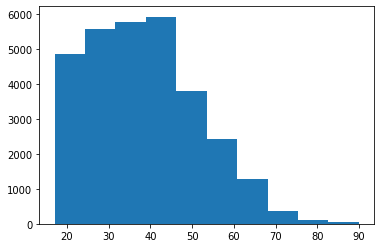

*** fnlwgt: 20263


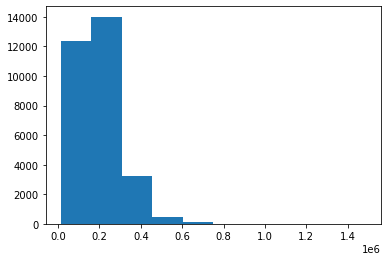

*** education_num: 16


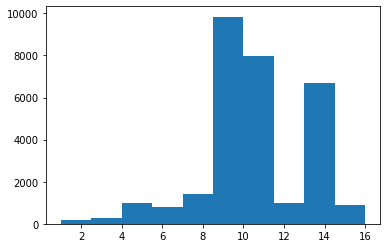

*** capital_gain: 118


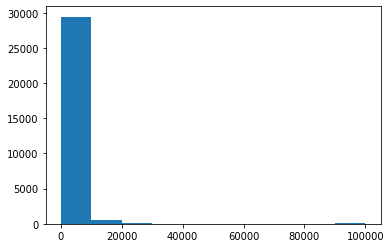

*** capital_loss: 90


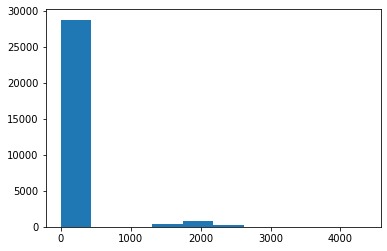

*** hours_per_week: 94


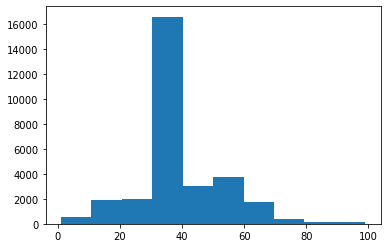

*** wage_class: 2


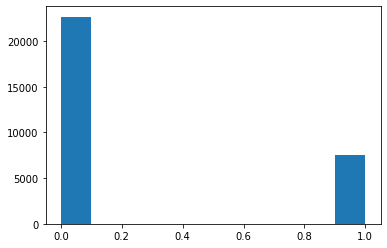

In [45]:
for col in num_columns:
    print(f'*** {col}: {train[col].nunique()}')
    plt.hist(train[col], bins=10)
    plt.show()
    

In [46]:
np.percentile(a=train['hours_per_week'], q=[1, 5, 10, 20, 30, 50, 60, 70, 80])

array([10., 20., 25., 36., 40., 40., 40., 42., 50.])

In [47]:
train['hours_per_week'].value_counts().head(10)

40    14251
50     2718
45     1753
60     1405
35     1184
20     1054
30      989
55      672
25      574
48      494
Name: hours_per_week, dtype: int64

In [48]:
train[train['hours_per_week']>40]['hours_per_week'].count()

9197

In [49]:
train[train['hours_per_week']<40]['hours_per_week'].count()

6714

In [50]:
train[train['hours_per_week']==40]['hours_per_week'].count()

14251

## Numerical columns - conclusion
* age (<30, 30-40, 40-50, 50-60, >60)
* fnlwgt = remove
* education_num = the number of years spent for education; keep as it is
* capital_gain = 0 or 1 (if made gain)
* capital_loss = 0 or 1 (if made loss)
* hours_per_week (<40, 40, >40)

### Categorical columns

*** workclass: 7


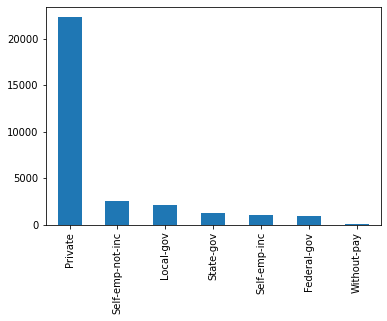

*** education: 16


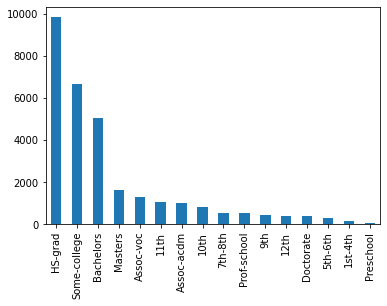

*** marital_status: 7


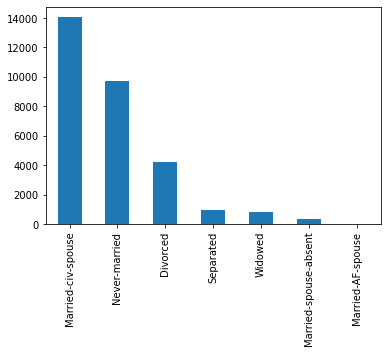

*** occupation: 14


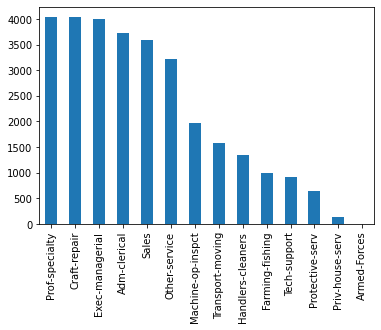

*** relationship: 6


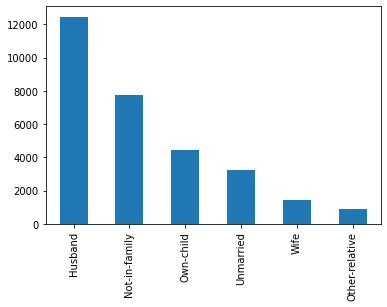

*** race: 5


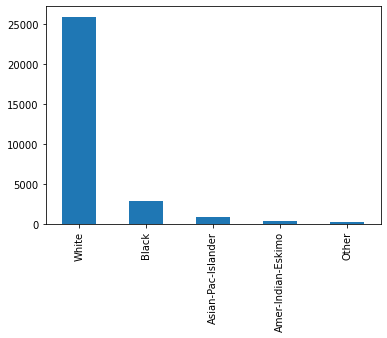

*** sex: 2


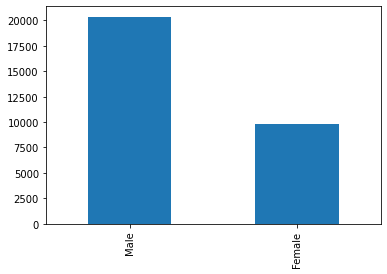

*** native_country: 41


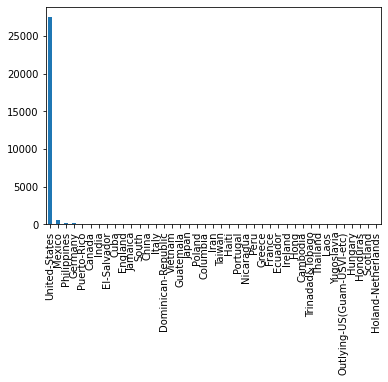

In [51]:
for col in cat_columns:
    print(f'*** {col}: {train[col].nunique()}')
    train[col].value_counts().plot.bar()
    plt.show()
    

In [52]:
train['native_country'].value_counts().head(10) 

United-States    27504
Mexico             610
Philippines        188
Germany            128
Puerto-Rico        109
Canada             107
India              100
El-Salvador        100
Cuba                92
England             86
Name: native_country, dtype: int64

In [53]:
train['native_country'].value_counts().head(10) / train.shape[0]

United-States    0.911876
Mexico           0.020224
Philippines      0.006233
Germany          0.004244
Puerto-Rico      0.003614
Canada           0.003548
India            0.003315
El-Salvador      0.003315
Cuba             0.003050
England          0.002851
Name: native_country, dtype: float64

In [54]:
train['race'].value_counts().head(10) / train.shape[0]

White                 0.859790
Black                 0.093396
Asian-Pac-Islander    0.029673
Amer-Indian-Eskimo    0.009482
Other                 0.007659
Name: race, dtype: float64

In [55]:
pd.crosstab(train.education,train.education_num)

education_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,820,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1048,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,377,0,0,0,0,0,0,0,0
1st-4th,0,151,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,288,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,557,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,455,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1008,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1307,0,0,0,0,0


### Group education into 3 classes:
* 1-8 - basic education;
* 9-10 years => the most often education
* 11-16 years => higher degree

In [56]:
# basic education = 1
train.education_num.value_counts().sort_index()[:8].sum()

3741

In [57]:
# middle level of education = 2
train.education_num.value_counts().sort_index()[8:10].sum()

16518

In [58]:
# higher degree = 3
train.education_num.value_counts().sort_index()[10:].sum()

9903

### Family Status

In [59]:
train.marital_status.value_counts() / train.shape[0]

Married-civ-spouse       0.466315
Never-married            0.322459
Divorced                 0.139712
Separated                0.031132
Widowed                  0.027419
Married-spouse-absent    0.012267
Married-AF-spouse        0.000696
Name: marital_status, dtype: float64

In [60]:
train.relationship.value_counts() / train.shape[0]

Husband           0.413202
Not-in-family     0.256150
Own-child         0.148067
Unmarried         0.106492
Wife              0.046615
Other-relative    0.029474
Name: relationship, dtype: float64

In [61]:
pd.crosstab(train.marital_status, train.relationship)

relationship,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
marital_status,,,,,,
Divorced,0,2268,103,308,1535,0
Married-AF-spouse,9,0,1,1,0,10
Married-civ-spouse,12454,14,118,83,0,1396
Married-spouse-absent,0,181,26,43,120,0
Never-married,0,4448,548,3929,801,0
Separated,0,383,53,90,413,0
Widowed,0,432,40,12,343,0


* marital_status => {married, never-married, other}
* relationship => {has_child, no}

## Occupation

In [62]:
a = train.groupby('occupation').mean()['wage_class'].sort_values(ascending=False)
a

occupation
Exec-managerial      0.485220
Prof-specialty       0.448489
Protective-serv      0.326087
Tech-support         0.304825
Sales                0.270647
Craft-repair         0.225310
Transport-moving     0.202926
Adm-clerical         0.133835
Machine-op-inspct    0.124619
Farming-fishing      0.116279
Armed-Forces         0.111111
Handlers-cleaners    0.061481
Other-service        0.041096
Priv-house-serv      0.006993
Name: wage_class, dtype: float64

In [63]:
import math

def roundup(x):
    return int(round(x / 10))

In [64]:
roundup(31), roundup(28)

(3, 3)

In [65]:
a = a.apply(lambda x: roundup(x))
a

occupation
Exec-managerial      0
Prof-specialty       0
Protective-serv      0
Tech-support         0
Sales                0
Craft-repair         0
Transport-moving     0
Adm-clerical         0
Machine-op-inspct    0
Farming-fishing      0
Armed-Forces         0
Handlers-cleaners    0
Other-service        0
Priv-house-serv      0
Name: wage_class, dtype: int64

In [66]:
occupation_d = a.to_dict()
occupation_d

{'Exec-managerial': 0,
 'Prof-specialty': 0,
 'Protective-serv': 0,
 'Tech-support': 0,
 'Sales': 0,
 'Craft-repair': 0,
 'Transport-moving': 0,
 'Adm-clerical': 0,
 'Machine-op-inspct': 0,
 'Farming-fishing': 0,
 'Armed-Forces': 0,
 'Handlers-cleaners': 0,
 'Other-service': 0,
 'Priv-house-serv': 0}

## Zadanie 
* zrobić enkodowanie dla kolumny 'Workclass'
* przygotować mapę

## Workclass

In [67]:
b = train.groupby('workclass').mean()['wage_class'].sort_values(ascending=False)
b

workclass
Self-emp-inc        0.558659
Federal-gov         0.387063
Local-gov           0.294630
Self-emp-not-inc    0.285714
State-gov           0.268960
Private             0.218792
Without-pay         0.000000
Name: wage_class, dtype: float64

In [68]:
b = b.apply(lambda x: roundup(x * 100))
b

workclass
Self-emp-inc        6
Federal-gov         4
Local-gov           3
Self-emp-not-inc    3
State-gov           3
Private             2
Without-pay         0
Name: wage_class, dtype: int64

In [69]:
workclass_d = b.to_dict()
workclass_d

{'Self-emp-inc': 6,
 'Federal-gov': 4,
 'Local-gov': 3,
 'Self-emp-not-inc': 3,
 'State-gov': 3,
 'Private': 2,
 'Without-pay': 0}

In [70]:
cat_columns

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

## Categorical Columns - Conclusion
* workclass => map using __workclass_d__
* education => remove but number of years split into 3 groups (1-8, 9-10, 11-16)
* marital_status => {married, never-married, other}
* occupation => map using __occupation_d__
* relationship => map to {has_child, no} or drop
* race => make binary (white or not)
* sex => binary (0=male, 1=female)
* native_coutry => make binary (US or not)
* wage class => target, to be predicted


In [71]:
num_columns

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'wage_class']

## Numerical columns - conclusion
* age => make binning (<35, 35-50, >50)
* fnlwgt => remove
* education_num => binning
* capital_gain = make binary (1 if made gain else 0)
* capital_loss = make binary (1 if made loss else 0)
* hours_per_week (<40, 40, >40)

In [72]:
df_train = train.copy()

### Transform numerical columns

In [73]:
# age
pd.cut(x=df_train['age'], bins=[0, 35, 50, 100], right=False, labels=[1, 2, 3]).value_counts()


1    12910
2    10985
3     6267
Name: age, dtype: int64

In [74]:
df_train['age'] = pd.cut(x=df_train['age'], bins=[0, 35, 50, 100], right=False, labels=[1, 2, 3])
df_train['age'] = df_train['age'].astype(int)

In [75]:
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [76]:
df_train = df_train.drop('fnlwgt', axis=1)
df_train.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,3,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,1,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [77]:
pd.cut?

## Zadanie
* zrobić binning dla kolumny Education Num
* przedziały
    * 1: do 8 lat; 
    * 2: od 9 do 10
    * 3: powyżej 10

In [78]:
# education

pd.cut(x=df_train.education_num, bins=[1, 9, 11, 20], right=False).value_counts()

[9, 11)     16518
[11, 20)     9903
[1, 9)       3741
Name: education_num, dtype: int64

In [79]:
df_train.education_num = pd.cut(x=df_train.education_num, bins=[1, 9, 11, 20], right=False, labels=[1, 2, 3])
df_train.education_num = df_train.education_num.astype(int)


In [80]:
df_train.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,State-gov,Bachelors,3,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,3,Self-emp-not-inc,Bachelors,3,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,2,Private,HS-grad,2,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,3,Private,11th,1,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,1,Private,Bachelors,3,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [81]:
# education => remove
df_train = df_train.drop('education', axis=1)

In [82]:
df_train.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,State-gov,3,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,3,Self-emp-not-inc,3,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,2,Private,2,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,3,Private,1,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,1,Private,3,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Zadanie 
* zrobić binarne enkodowanie kolumn __Capital Loss__ i __Capital Gain__ 

In [83]:
# capital gain and loss

df_train.capital_gain = df_train.capital_gain.apply(lambda x: 1 if x > 0 else 0)
df_train.capital_loss = df_train.capital_loss.apply(lambda x: 1 if x > 0 else 0)

In [84]:
df_train.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,State-gov,3,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,40,United-States,0
1,3,Self-emp-not-inc,3,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,2,Private,2,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,3,Private,1,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,1,Private,3,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Zadanie 
* zrobić binning dla ilości godzin pracy
* przedziały: <40; 40; >40
* jak przedstawić jeden punkt (40), a nie przedział?

In [85]:
# hours per week

pd.cut(x=df_train.hours_per_week, bins=[0, 39.9, 40.1, 100], right=False).value_counts()

[39.9, 40.1)     14251
[40.1, 100.0)     9197
[0.0, 39.9)       6714
Name: hours_per_week, dtype: int64

In [86]:
df_train.hours_per_week = pd.cut(x=df_train.hours_per_week, bins=[0, 39.9, 40.1, 100], right=False, labels=[1, 2, 3])
df_train.hours_per_week = df_train.hours_per_week.astype(int)

In [87]:
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Transform categorical columns
* workclass => map using workclass_d
* education => remove but number of years split into 3 groups (1-8, 9-10, 11-16)
* marital_status => {married, never-married, other}
* occupation => map using occupation_d
* relationship => map to {has_child, no} or drop
* race => make binary (white or not)
* sex => binary (0=male, 1=female)
* native_coutry => make binary (US or not)
* wage class => target, to be predicted

In [88]:
df_train.workclass = df_train.workclass.map(workclass_d)

In [89]:
df_train.head(2)

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,3,3,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,0
1,3,3,3,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,1,United-States,0


In [90]:
def map_marital_status(x):
    if x not in ['Married-civ-spouse', 'Never-married']:
        return 'Other'
    else:
        return x

In [91]:
df_train.marital_status = df_train.marital_status.apply(lambda x: map_marital_status(x))

In [92]:
df_train.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,3,3,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,0
1,3,3,3,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,1,United-States,0
2,2,2,2,Other,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,0
3,3,2,1,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,0
4,1,2,3,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,0


## Zadanie
* zrobić enkodowanie kolumny Occupation
* zrobić kolumny do postaci binarnej -> Relationship, Sex, Race, Native Country 

In [93]:
# occupation
df_train.occupation = df_train.occupation.map(occupation_d)

In [94]:
df_train.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,3,3,Never-married,0,Not-in-family,White,Male,1,0,2,United-States,0
1,3,3,3,Married-civ-spouse,0,Husband,White,Male,0,0,1,United-States,0
2,2,2,2,Other,0,Not-in-family,White,Male,0,0,2,United-States,0
3,3,2,1,Married-civ-spouse,0,Husband,Black,Male,0,0,2,United-States,0
4,1,2,3,Married-civ-spouse,0,Wife,Black,Female,0,0,2,Cuba,0


In [95]:
df_train.relationship.unique()

array(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)

In [96]:
# relationship

df_train.relationship = df_train.relationship.apply(lambda x: 1 if x=='Own-child' else 0)

In [97]:
df_train.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,3,3,Never-married,0,0,White,Male,1,0,2,United-States,0
1,3,3,3,Married-civ-spouse,0,0,White,Male,0,0,1,United-States,0
2,2,2,2,Other,0,0,White,Male,0,0,2,United-States,0
3,3,2,1,Married-civ-spouse,0,0,Black,Male,0,0,2,United-States,0
4,1,2,3,Married-civ-spouse,0,0,Black,Female,0,0,2,Cuba,0


In [98]:
df_train.race = df_train.race.apply(lambda x: 1 if x=='White' else 0)

In [99]:
df_train.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,3,3,Never-married,0,0,1,Male,1,0,2,United-States,0
1,3,3,3,Married-civ-spouse,0,0,1,Male,0,0,1,United-States,0
2,2,2,2,Other,0,0,1,Male,0,0,2,United-States,0
3,3,2,1,Married-civ-spouse,0,0,0,Male,0,0,2,United-States,0
4,1,2,3,Married-civ-spouse,0,0,0,Female,0,0,2,Cuba,0


In [100]:
df_train.sex = df_train.sex.apply(lambda x: 1 if x=='Female' else 0)

In [101]:
df_train.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,3,3,Never-married,0,0,1,0,1,0,2,United-States,0
1,3,3,3,Married-civ-spouse,0,0,1,0,0,0,1,United-States,0
2,2,2,2,Other,0,0,1,0,0,0,2,United-States,0
3,3,2,1,Married-civ-spouse,0,0,0,0,0,0,2,United-States,0
4,1,2,3,Married-civ-spouse,0,0,0,1,0,0,2,Cuba,0


In [102]:
df_train.native_country = df_train.native_country.apply(lambda x: 1 if x=='United-States' else 0)

In [103]:
df_train.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,2,3,3,Never-married,0,0,1,0,1,0,2,1,0
1,3,3,3,Married-civ-spouse,0,0,1,0,0,0,1,1,0
2,2,2,2,Other,0,0,1,0,0,0,2,1,0
3,3,2,1,Married-civ-spouse,0,0,0,0,0,0,2,1,0
4,1,2,3,Married-civ-spouse,0,0,0,1,0,0,2,0,0


In [104]:
df_train.marital_status.unique()

array(['Never-married', 'Married-civ-spouse', 'Other'], dtype=object)

In [105]:
pd.get_dummies(df_train, drop_first=True)

,age,workclass,education_num,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class,marital_status_Never-married,marital_status_Other
0,2,3,3,0,0,1,0,1,0,2,1,0,1,0
1,3,3,3,0,0,1,0,0,0,1,1,0,0,0
2,2,2,2,0,0,1,0,0,0,2,1,0,0,1
3,3,2,1,0,0,0,0,0,0,2,1,0,0,0
4,1,2,3,0,0,0,1,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,1,2,3,0,0,1,1,0,0,1,1,0,0,0
32557,2,2,2,0,0,1,0,0,0,2,1,1,0,0
32558,3,2,2,0,0,1,1,0,0,2,1,0,0,1
32559,1,2,2,0,1,1,0,0,0,1,1,0,1,0


In [106]:
pd.get_dummies?

## Zadanie
1. przygotować funkcję, który krok po kroku przeprowadza transformację datasetu od postaci surowej do postaci pożądanej:
    * usuwanie wartości brakujących
    * enkodowanie targetu
    * usuwanie "zbędnych" kolumn
    * transformowanie kolumn numerycznych
    * trnasformowanie kolumn kategorycznych
2. Wczytać ponownie dane surowe  
3. Zrobić transformację części treningowej oraz testowej


In [107]:
def prepare_dataset(df):
    # missing values
    df = df.replace('?', np.nan).dropna() 
    
    # target
    df['wage_class'] = df.wage_class.replace({'<=50K': 0, '<=50K.': 0, '>50K': 1, '>50K.': 1})
    
    # numerical columns
    df['age'] = pd.cut(x=df['age'], bins=[0, 35, 50, 100], right=False, labels=[1, 2, 3])
    df['age'] = df['age'].astype(int)
    
    df = df.drop('fnlwgt', axis=1)
    df.education_num = pd.cut(x=df.education_num, bins=[1, 9, 11, 20], right=False, labels=[1, 2, 3])
    df.education_num = df.education_num.astype(int)
    
    df.capital_gain = df.capital_gain.apply(lambda x: 1 if x > 0 else 0)
    df.capital_loss = df.capital_loss.apply(lambda x: 1 if x > 0 else 0)

    df.hours_per_week = pd.cut(x=df.hours_per_week, bins=[0, 39.9, 40.1, 100], right=False, labels=[1, 2, 3])
    df.hours_per_week = df.hours_per_week.astype(int)

    # categorical columns
    df = df.drop('education', axis=1)
    df.workclass = df.workclass.map(workclass_d)
    df.marital_status = df.marital_status.apply(lambda x: map_marital_status(x))
    df.occupation = df.occupation.map(occupation_d)
    df.relationship = df.relationship.apply(lambda x: 1 if x=='Own-child' else 0)
    df.race = df.race.apply(lambda x: 1 if x=='White' else 0)
    df.sex = df.sex.apply(lambda x: 1 if x=='Female' else 0)
    df.native_country = df.native_country.apply(lambda x: 1 if x=='United-States' else 0)
    return pd.get_dummies(df, drop_first=True)


In [109]:
train = pd.read_csv('Dane/adult.data', sep = ",",skipinitialspace=True,  header = None)
test = pd.read_csv('Dane/adult.test', sep = "," ,skiprows = [0], skipinitialspace=True, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train.columns = col_labels
test.columns = col_labels

In [110]:
train_df = prepare_dataset(train)
train_df.head()

,age,workclass,education_num,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class,marital_status_Never-married,marital_status_Other
0,2,3,3,0,0,1,0,1,0,2,1,0,1,0
1,3,3,3,0,0,1,0,0,0,1,1,0,0,0
2,2,2,2,0,0,1,0,0,0,2,1,0,0,1
3,3,2,1,0,0,0,0,0,0,2,1,0,0,0
4,1,2,3,0,0,0,1,0,0,2,0,0,0,0


In [111]:
train_df.shape

(30162, 14)

In [112]:
test_df = prepare_dataset(test)
test_df.head()

,age,workclass,education_num,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class,marital_status_Never-married,marital_status_Other
0,1,2,1,0,1,0,0,0,0,2,1,0,1,0
1,2,2,2,0,0,1,0,0,0,3,1,0,0,0
2,1,3,3,0,0,1,0,0,0,2,1,1,0,0
3,2,2,2,0,0,0,0,1,0,2,1,1,0,0
5,1,2,1,0,0,1,0,0,0,1,1,0,1,0


In [113]:
test_df.isna().sum()

age                             0
workclass                       0
education_num                   0
occupation                      0
relationship                    0
race                            0
sex                             0
capital_gain                    0
capital_loss                    0
hours_per_week                  0
native_country                  0
wage_class                      0
marital_status_Never-married    0
marital_status_Other            0
dtype: int64

In [114]:
target_col = 'wage_class'
X_train, y_train = train_df.drop(target_col, axis=1), train_df[target_col]
X_test, y_test = test_df.drop(target_col, axis=1), test_df[target_col]

In [115]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.8337981407702523

## Zadanie
* zrobić tuningowanie parametrów z użyciem Randomized Search

In [ ]:
xgb = XGBClassifier()
params = {"n_estimators":[10,100,200],
         "learning_rate":ss.uniform(0.01,0.3),
          "max_depth": ss.randint(5,30),
         "min_child_weight":ss.randint(5,50),
         "reg_lambda":ss.uniform(0.1,3)}

cv = RandomizedSearchCV(cv=3, 
                        estimator=xgb,
                        param_distributions=params,
                        n_iter=10,
                        verbose=100)
cv.fit(X_train,y_train)

In [ ]:
cv.score(X_test, y_test)

## Bonus: Hyperopt

In [ ]:
from hyperopt import hp, tpe, Trials, space_eval
from hyperopt.fmin import fmin
from hyperopt.plotting import main_plot_history
from sklearn.model_selection import cross_val_score

def objective(space):
    clf = XGBClassifier(n_estimators = space['n_estimators'],
                           max_depth = space['max_depth'],
                           learning_rate = space['learning_rate'],
                           reg_alpha = space['reg_alpha'],
                           reg_lambda = space['reg_lambda']
                           )
    print('XGB is configured ...')
    print(space)
    
    score = cross_val_score(clf, X_train, y_train, cv=3, verbose=1)
    # score -> list of validation scores 
    
    return -np.mean(score) # because function is minimizing only

# search space
space = {'max_depth': hp.choice('max_depth', np.arange(2, 20, 1,  dtype=int)),
         'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, 50,  dtype=int)),
         'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(1)),
         'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
         'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)
        }

# object for keeping the optimization information
trials = Trials()

# optimization process 
fmin(fn=objective,      # objective function
     space=space,       # search space
     algo=tpe.suggest,  # algorithm for optimization
     max_evals=10,     # how many different combinations we try
     trials=trials)     # object to keep the optimization process
     
params = space_eval(space, trials.argmin)
params

In [ ]:
y_test.mean()